In [1]:
import sys
sys.path.append('../')
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import ScalarFormatter
import fitz  # PyMuPDF
from PIL import Image
import io
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from symmetry_breaking_measure import Nickel, ReflectionOperator
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

BLUE, RED, YELLOW, MIDDLE = '#0B3C5D', '#B82601', '#D9B310', '#a8b6c1'
font_size = 20
axis = [0,0,1]

NUM_SAMPLES = 50000
CONFIDENCE_LEVEL = .95
TOLERANCE_ONE_SIDE = .0025
NUM_D = 50

# Cubic solid cut off from Nickel (length=1)
nickel = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
axis = np.matmul(np.array([0, 0, 1]), nickel._lattice.stdbase)
origin = nickel.xyz.mean(axis=0)
reflection_op = ReflectionOperator(axis=axis, origin=origin)
method = 'JS'

atoms_idx_in_plane = np.where(nickel.xyz[:,2] == nickel.xyz[:,2].max()/2)[0]
atoms_idx_out_of_plane = np.where(nickel.xyz[:,2] != nickel.xyz[:,2].max()/2)[0]

# The violation of symmetry elements of local distorted Nickel

In [2]:
def perturbation_arr(deviation_angle, radius=1):
    if deviation_angle == 0:
        dir = np.array([[1, 0, 0], [np.sqrt(2)/2, np.sqrt(2)/2, 0]])
    elif deviation_angle == 45:
        dir = np.array([[np.sqrt(2)/2, 0, np.sqrt(2)/2], [1/2, 1/2, np.sqrt(2)/2]])
    elif deviation_angle == 90:
        dir = np.array([[0, 0, 1]])
    result = dir * radius
    return result

def initiate_distorted_nickel(idx, perturbation_dir, disp):
    nickel = Nickel(cutoff='rectangular_solid', cutout_x=1, cutout_y=1, cutout_z=1)
    xyz_distorted = nickel.xyz
    xyz_distorted[idx,:3] += perturbation_dir * disp
    nickel.set_xyz(xyz_distorted)
    return nickel

def calc_variance_sample_size_from_nickel(nickel_structure, op, method, **operator_kwrgs):
    sample_size, _ = nickel_structure.calc_symmetry_breaking_measure_sample_size(
        num_samples=NUM_SAMPLES,
        operator=op,
        confidence_interval=CONFIDENCE_LEVEL,
        tolerance_single_side=TOLERANCE_ONE_SIDE,
        method=method,
        **operator_kwrgs
        )
    return sample_size

def compute_sbm(args):
    idx, perturbation, disp = args
    nickel_structure = initiate_distorted_nickel(idx, perturbation, disp)
    sample_size = calc_variance_sample_size_from_nickel(nickel_structure, reflection_op, method=method)
    measure = nickel_structure.calc_symmetry_breaking_measure(
        num_samples=sample_size,
        operator=reflection_op,
        method=method
    )
    return [disp, measure, sample_size[-1]]
    
def construct_tasks(disp_list, atoms_idx_set, deviation_angle):
    tasks = []
    perturbations = perturbation_arr(deviation_angle)
    for idx in atoms_idx_set:
        for perturbation in perturbations:
            for disp in disp_list:
                tasks.append((idx, perturbation, disp))
    return tasks

def compute_sbm_multiprocessing(
    max_disp,
    in_plane,
    save_filedir: str = None
):
    disp_list = np.linspace(0, max_disp, int(NUM_D * max_disp))
    measures = []
    if in_plane:
        atoms_idx_set = atoms_idx_in_plane
    else:
        atoms_idx_set = atoms_idx_out_of_plane
    for deviation_angle in tqdm([0, 45, 90]):
        tasks = construct_tasks(disp_list, atoms_idx_set, deviation_angle)
        with Pool(processes=cpu_count()) as pool:
            measures_deviation_angle = list(tqdm(pool.imap(compute_sbm, tasks), total=len(tasks)))
        measures.append(measures_deviation_angle)
    if save_filedir:
        # Row in saved file: d, measure, sample_size
        np.savetxt(save_filedir, measures, delimiter=',') 
    return measures

In [3]:
# in-plane atoms
measures_in_plane_0, measures_in_plane_45, measures_in_plane_90 = compute_sbm_multiprocessing(max_disp=4, in_plane=True, save_filedir=None)

100%|██████████| 3/3 [02:15<00:00, 45.06s/it]


In [4]:
# out-of-plane atoms
measures_out_of_plane_0, measures_out_of_plane_45, measures_out_of_plane_90 = compute_sbm_multiprocessing(max_disp=3, in_plane=False, save_filedir=None)

100%|██████████| 3/3 [05:16<00:00, 105.42s/it]


# Paper Section 5.1.2 - Plot

In [8]:
def convert_pdf_to_image(pdf_path, page_number=0, zoom=2.0):
    # Open the PDF file
    doc = fitz.open(pdf_path)
    page = doc.load_page(page_number)  # Get the page (0-based index)
    # Convert the page to an image
    matrix = fitz.Matrix(zoom, zoom)  # Zoom factor for higher resolution
    pix = page.get_pixmap(matrix=matrix)
    # Convert the Pixmap object to a PIL Image
    image = Image.open(io.BytesIO(pix.tobytes("png")))
    doc.close()
    return image

def plot(data, xlabel, ylabel, xlim, ylim, filename=None, style=None, text=None, solid=None, extra_data=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 4)
    plt.style.use(style)
    rc('text', usetex=True)
    plt.rcParams.update({
        'text.latex.preamble': r'\usepackage{mathrsfs} \usepackage{sansmath} \sansmath'  # Using sansmath package for sans-serif
    })
    
    for curve in data.values():
        ax.scatter(curve['x'], curve['y'], s=1, color=curve['color'], alpha=0.7)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    if ylabel == 'Sample Size':
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # Force scientific notation
        ax.yaxis.get_offset_text().set_fontsize(font_size)  # Set the font size to match tick labels
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size) 
    
    if extra_data:
        for curve in extra_data:
            ax.plot(curve['x'], curve['y'], linestyle=curve['linestyle'], color=curve['color'], alpha=0.5)
    
    if text:
        ax_text = fig.add_axes(text['loc'])
        ax_text.text(0, 0, text['content'], fontsize=22)
        ax_text.set_axis_off()
        
    if solid:
        img = convert_pdf_to_image(solid['directory'])
        ax_rectangular_solid = fig.add_axes(solid['loc'])
        ax_rectangular_solid.imshow(img)
        ax_rectangular_solid.set_axis_off()

    plt.show()
    if filename:
        fig.savefig(filename)

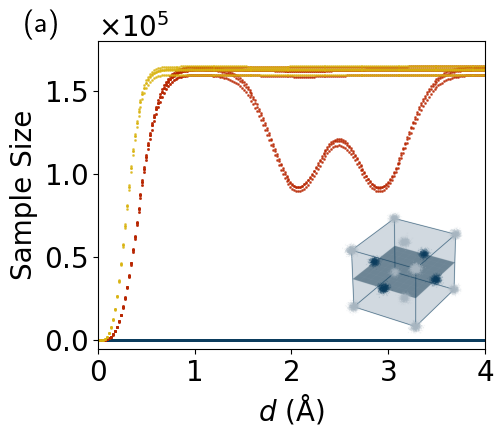

In [5]:
# sample size - in_plane
measures_in_plane_0 = np.array(measures_in_plane_0)
measures_in_plane_45 = np.array(measures_in_plane_45)
measures_in_plane_90 = np.array(measures_in_plane_90)
data = {1:{'x': measures_in_plane_0[:,0], 'y': measures_in_plane_0[:,2], 'color': BLUE}, 
        2:{'x': measures_in_plane_45[:,0], 'y': measures_in_plane_45[:,2], 'color': RED}, 
        3:{'x': measures_in_plane_90[:,0], 'y': measures_in_plane_90[:,2], 'color': YELLOW}}
plot(data, xlabel=r'$\mathit{d}$ ($\mathrm{\AA}$)', ylabel='Sample Size', xlim=[0,4], ylim=[-5000,180000], 
     filename='../figs/nickel/reflection_in_plane_samplesize.pdf', style=bg_mpl_style, 
     text={'content':'(a)', 'loc':[-0.02, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_in_plane_nobackground.pdf', 'loc':[0.58, 0.14, 0.32, 0.32]})

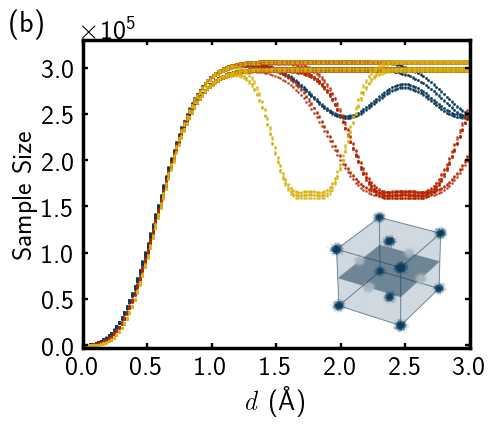

In [27]:
# sample size - out_of_plane
measures_out_of_plane_0 = np.array(measures_out_of_plane_0)
measures_out_of_plane_45 = np.array(measures_out_of_plane_45)
measures_out_of_plane_90 = np.array(measures_out_of_plane_90)
data = {1:{'x': measures_out_of_plane_0[:,0], 'y': measures_out_of_plane_0[:,2], 'color': BLUE}, 
        2:{'x': measures_out_of_plane_45[:,0], 'y': measures_out_of_plane_45[:,2], 'color': RED}, 
        3:{'x': measures_out_of_plane_90[:,0], 'y': measures_out_of_plane_90[:,2], 'color': YELLOW}}
plot(data, xlabel=r'$\mathit{d}$ ($\mathrm{\AA}$)', ylabel='Sample Size', xlim=[0,3], ylim=[-3000,330000], 
     filename='../figs/nickel/reflection_out_of_plane_samplesize.pdf', style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[-0.02, .9, 0, 0]}, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_out_of_plane_nobackground.pdf', 'loc':[0.58, 0.14, 0.32, 0.32]})

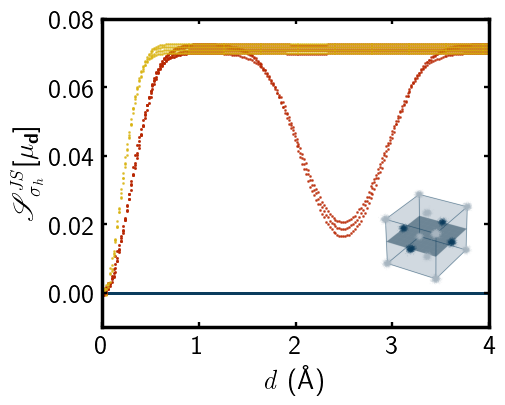

In [28]:
# in-plane sbm no label
data = {1:{'x': measures_in_plane_0[:,0], 'y': measures_in_plane_0[:,1], 'color': BLUE}, 
        2:{'x': measures_in_plane_45[:,0], 'y': measures_in_plane_45[:,1], 'color': RED}, 
        3:{'x': measures_in_plane_90[:,0], 'y': measures_in_plane_90[:,1], 'color': YELLOW}}
plot(data, xlabel=r'$\mathit{d}$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\sigma_\mathit{h}}[\mu_\mathbf{d}]$',
     xlim=[0,4], ylim=[-0.01,0.08], 
     filename='../figs/nickel/reflection_in_plane_nolabel.pdf', style=bg_mpl_style, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_in_plane_nobackground.pdf', 'loc':[0.65, 0.21, 0.25, 0.25]})

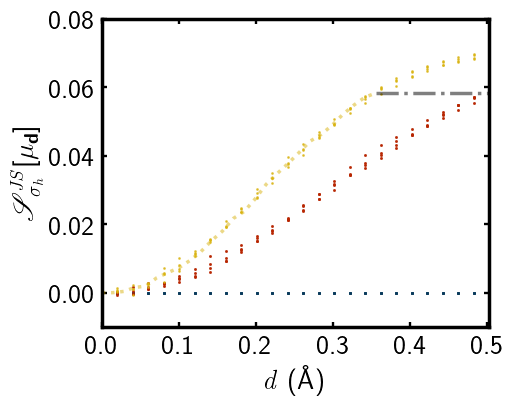

In [11]:
# in-plane sbm - sqrt2
x_max = 25
dx, dy = measures_in_plane_45[:,0], measures_in_plane_45[:,1]
data = {1:{'x': measures_in_plane_0[:,0], 'y': measures_in_plane_0[:,1], 'color': BLUE}, 
        2:{'x': measures_in_plane_45[:,0], 'y': measures_in_plane_45[:,1], 'color': RED}, 
        3:{'x': measures_in_plane_90[:,0], 'y': measures_in_plane_90[:,1], 'color': YELLOW}}
line_1 = {'x':dx[:x_max+1]/np.sqrt(2), 'y':dy[:x_max+1], 'linestyle': ':', 'color': YELLOW}
line_2 = {'x':[dx[x_max]/np.sqrt(2), dx[x_max]], 'y':[dy[x_max],dy[x_max]], 'linestyle': '-.', 'color': 'k'}
extra_data = [line_1, line_2]
plot(data, xlabel=r'$\mathit{d}$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\sigma_\mathit{h}}[\mu_\mathbf{d}]$',
     xlim=[0,dx[x_max]], ylim=[-0.01,0.08], 
     filename='../figs/nickel/reflection_in_plane_sqrt2.pdf', style=bg_mpl_style, 
     solid=None, extra_data=extra_data)

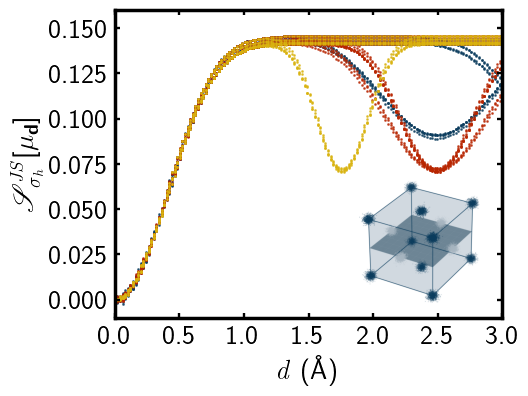

In [23]:
# out-of-plane - nolabel
data = {1:{'x': measures_out_of_plane_0[:,0], 'y': measures_out_of_plane_0[:,1], 'color': BLUE}, 
        2:{'x': measures_out_of_plane_45[:,0], 'y': measures_out_of_plane_45[:,1], 'color': RED}, 
        3:{'x': measures_out_of_plane_90[:,0], 'y': measures_out_of_plane_90[:,1], 'color': YELLOW}}
plot(data, xlabel=r'$\mathit{d}$ ($\mathrm{\AA}$)', ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\sigma_\mathit{h}}[\mu_\mathbf{d}]$',
     xlim=[0,3], ylim=[-0.01,0.16], 
     filename='../figs/nickel/reflection_out_of_plane_nolabel.pdf', style=bg_mpl_style, 
     solid={'directory':'../figs/nickel/cubic_solid_nickel_samples_out_of_plane_nobackground.pdf', 'loc':[0.58, 0.14, 0.32, 0.32]})